# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your https://jupyterhub.ischool.syr.edu/ workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# load these packages
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, classification, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

# Part 2: Multilayer perceptrons:

**Note 1**: Due to the memory requirements of MLPs and the limitations of the server `notebook.acuna.io`, you cannot run should not run multiple jupyter notebooks at the same time or your account might run out of memory. You can check which notebooks are opened by going to http://notebook.acuna.io/#running. Shutdown the ones that you no longer need.

**Note 2**: Due to the time it takes to fit some of this model, if you want to validate your entire notebook, instead of clicking `Validate` which may fail, I would advise you to go to `Kernel` -> `Restart and Run All`. If all tests pass, it is equivalent to `Validate`.

## **Question 1 (10 pts):** 
Choose the best model based on accuracy between multilayer perceptrons predicting whether a face is from an `old` person or not based on `pixels`. Compare the following architectures:

 1. No hidden layers
 1. One hidden layer with 15 neurons
 1. Two Hidden layers with 30 neurons each

Fit both models to `training` and estimate the AUC on validation. You don't need to build a Pipeline because the features needed are in the column `pixels`. Pick the best one based on validation performance. The input dimension is 2304 (=48\*48) and the output is 2. Store the first, second, and third models in the variables `mlp_model1`, `mlp_model2`, and `mlp_model3`. Additionally, fit a logistic regression model and call it `lr_model`. Store the AUC on `AUC1`, `AUC2`, `AUC3`, and `AUC_lr`. Based on these performances, store the best model in `best_model`. Use the default paramerts for all the neural networks.

In [2]:
# read data
# pixels: 48x48 pixel gray values (between 0 and 255) 
utkface_df = spark.read.parquet('faces.parquet').\
    withColumn('old', (fn.col('age')>30).cast('int'))

# use these splits throughout the homework
training, validation, testing = utkface_df.randomSplit([0.6, 0.3, 0.1], seed=0)

# to compute AUC use the following evaluator
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='old')

In [3]:
# utility function to display the first element of a Spark dataframe as an image
def display_first_as_img(df):
    plt.figure()
    plt.imshow(df.first().pixels.reshape([48,48]), 'gray');

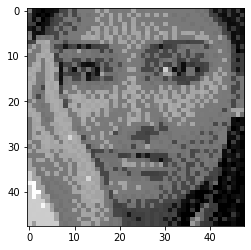

In [7]:
# show random faces
display_first_as_img(utkface_df.where('old=0').orderBy(fn.rand()))

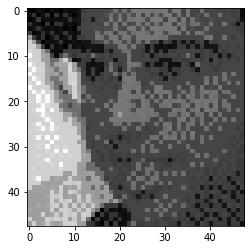

In [8]:
# show random faces
display_first_as_img(utkface_df.where('old=1').orderBy(fn.rand()))

In [9]:
# no hidden layers 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
model1=MultilayerPerceptronClassifier(featuresCol='pixels', labelCol='old', layers = [2304,2])
mlp_model1 = model1.fit(training)
pred = mlp_model1.transform(validation)
evaluator = BinaryClassificationEvaluator(labelCol = 'old', metricName = "areaUnderROC")
AUC1 = evaluator.evaluate(pred)
print("AUC for no hidden layers:", AUC1)

AUC for no hidden layers: 0.6862665766938653


In [ ]:
# 15 neurons
from pyspark.ml.evaluation import BinaryClassificationEvaluator
model2=MultilayerPerceptronClassifier(featuresCol='pixels', labelCol='old', layers = [2304,15, 2])
mlp_model2 = model2.fit(training)
pred = mlp_model2.transform(validation)
evaluator = BinaryClassificationEvaluator(labelCol = 'old', metricName = "areaUnderROC")
AUC2 = evaluator.evaluate(pred)
print("AUC for 15 neurons:", AUC2)

In [ ]:
# 30 neurons
model3=MultilayerPerceptronClassifier(featuresCol='pixels', labelCol='old', layers = [2304,30,30, 2])
mlp_model3 = model3.fit(training)
pred = mlp_model3.transform(validation)
evaluator = BinaryClassificationEvaluator(labelCol = 'old', metricName = "areaUnderROC")
AUC3 = evaluator.evaluate(pred)
print("AUC for 30 neurons:", AUC3)

In [ ]:
lr = classification.LogisticRegression(featuresCol='pixels', labelCol='old')
lr_model = lr_model.fit(training)
pred = lr_model.transform(validation)
evaluator = BinaryClassificationEvaluator(labelCol = 'old', metricName = "areaUnderROC")
AUC_lr = evaluator.evaluate(pred)
print("AUC for logistic regression:", AUC_lr)

In [ ]:
best_model = lr_model

In [ ]:
# 10 points
assert type(mlp_model1) == classification.MultilayerPerceptronClassificationModel
assert type(mlp_model2) == classification.MultilayerPerceptronClassificationModel
assert type(mlp_model3) == classification.MultilayerPerceptronClassificationModel
assert (type(best_model) == classification.MultilayerPerceptronClassificationModel or 
        type(best_model) == classification.LogisticRegressionModel)

## **Question 2 (10 pts)**: 

Study neural network architectures to fit the infamous two-spirals dataset. There is boilerplate code to do the data generation, plotting and evaluation. Play with number of hidden layers and with the number of neurons per hidden layer but **limit the number of total weights to no more than 250 to achieve an accuracy greater than 72%**. *Set `seed=5` and you can also increase the parameter `maxIter` to improve the performance*. You have to figure out input and output dimension. Use the convenience function `fit_and_plot` to fit an estimator. Assign the fitted model to a variable `my_mlp`. Look at the example with logistic regression. 

In [3]:
# BOILERPLATE CODE
from sklearn import manifold, datasets
from pyspark.sql import Row
import numpy as np
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

# X, y = datasets.make_circles(n_samples=300, factor=.6, noise=.1, random_state=0)
data = spark.createDataFrame(  [Row(x=float(x[0]), y=float(x[1]), label=int(label)) for x, label in zip(X, y)])

plotting_data = spark.range(100).selectExpr("(id - 50)/3 as x").\
  crossJoin(spark.range(100).selectExpr("(id - 50)/3 as y"))

  
def fit_and_plot(estimator):
    """Plot the data and decision surface of estimator"""    
    
    plt.figure()
    va= feature.VectorAssembler(inputCols=['x', 'y'], outputCol='features')
    
    model = estimator.fit(va.transform(data))
    
    df = va.transform(plotting_data)    
    pp = model.transform(df).select('x', 'y', 'prediction').toPandas()

    fig, ax = plt.subplots(figsize=(5,5))
    plt.contourf(pp.x.unique(), pp.y.unique(), 
                 pp.prediction.values.reshape(pp.x.unique().shape[0], 
                                              pp.x.unique().shape[0]).T, alpha=0.5)
    colors=['blue', 'red']
    for i, grp in data.toPandas().groupby('label'):
        grp.plot(x='x', y='y', kind='scatter', ax=ax,color=colors[i])  

    acc = model.transform(va.transform(data)).\
        selectExpr('avg(CAST((label = prediction) AS FLOAT)) AS avg').first().avg
    plt.title('Accuracy = {}'.format(acc))
    plt.show()
    return model

def ts_accuracy(model):
    va= feature.VectorAssembler(inputCols=['x', 'y'], outputCol='features')
    acc = model.transform(va.transform(data)).\
        selectExpr('avg(CAST((label = prediction) AS FLOAT)) AS avg').first().avg
    return acc

In [4]:
# Input Shape
print(X.shape)

(2000, 2)


In [5]:
# Output Dimension
print(set(y))

{0.0, 1.0}


<Figure size 432x288 with 0 Axes>

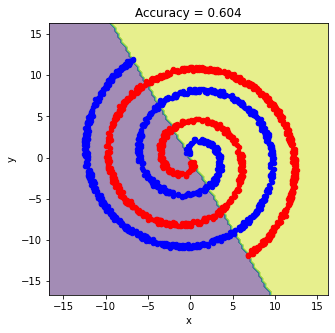

Model accuracy:  0.604


In [6]:
# example estimator that is not very good
# the plot shows the performance
ts_model = fit_and_plot(classification.LogisticRegression())
# but also you can examine it with ts_accuracy
print("Model accuracy: ", ts_accuracy(ts_model))

<Figure size 432x288 with 0 Axes>

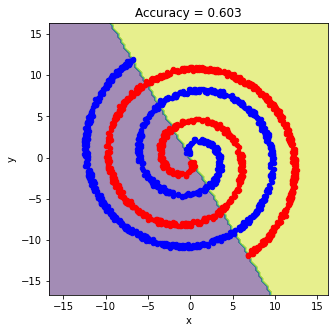

Model accuracy:  0.603


In [7]:
# example multilayer perceptron with no hidden layers
# the plot shows the performance
ts_model = fit_and_plot(classification.MultilayerPerceptronClassifier(layers=[2, 2]))
# but also you can examine it with ts_accuracy
print("Model accuracy: ", ts_accuracy(ts_model))

<Figure size 432x288 with 0 Axes>

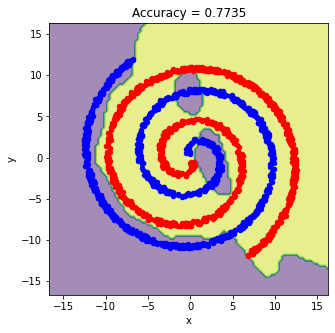

Model accuracy:  0.7735
169


In [40]:
# your answer here
# provide your answer below. The model estimator should be a MultilayerPerceptronClassifier. 
# Play with the layers and maxIter but not exceed the weights beyond 250 to achieve more than 75% accuracy
# YOUR CODE HERE
my_mlp = fit_and_plot(classification.MultilayerPerceptronClassifier(layers=[2, 20, 3, 5, 3, 2]))
# but also you can examine it with ts_accuracy
print("Model accuracy: ", ts_accuracy(my_mlp))
print(len(my_mlp.weights))

In [41]:
# 20 pts
assert type(my_mlp) == classification.MultilayerPerceptronClassificationModel
assert len(my_mlp.weights) <= 250
np.testing.assert_array_less(0.75, ts_accuracy(my_mlp))